Run Word2Vec on LOTR movie books using Skip Gram
=============

------------

The goal of this assignment is to train a Word2Vec skip-gram model over [LOTR movie](http://ae-lib.org.ua/texts-c/tolkien__the_lord_of_the_rings_1__en.htm) data.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import re
import tensorflow as tf
import zipfile
import glob
import nltk
import seaborn as sns
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
import codecs
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

## 1. Download the data from http://ae-lib.org.ua/texts-c/tolkien__the_lord_of_the_rings_1__en.htm

In [4]:
book_filenames = sorted(glob.glob("lotr/*.txt"))
print (book_filenames)


['lotr/1.txt', 'lotr/2.txt', 'lotr/3.txt']


## 2. Download NLTK data

In [5]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/kdalwani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kdalwani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3. Read LOTR files

### 3.1 Read all the text in one string

In [6]:
import pdb

def read_data(book_filename):
  print("Reading '{0}'...".format(book_filename)) 
  
  with codecs.open(book_filename, "r", "utf-8") as book_file:
      corpus_raw = book_file.read()
      return corpus_raw
        
corpus_raw = u""
for file_path in book_filenames:
    corpus_raw += (read_data(file_path)) + " "
print("Corpus is now {0} characters long".format(len(corpus_raw)))
print("Corpus has {0} unique characters long".format(len(set(corpus_raw))))

#       raw_sentences = tokenizer.tokenize(corpus_raw)
#       pdb.set_trace()
#       tokens.extend(raw_sentences.strip().split())


Reading 'lotr/1.txt'...
Reading 'lotr/2.txt'...
Reading 'lotr/3.txt'...
Corpus is now 2524737 characters long
Corpus has 104 unique characters long


In [7]:
def print_sample_data(data_set, sample_length):
    len_dat = len(data_set)
    start_index = np.random.randint(len_dat)
    sample_length = np.minimum(sample_length, len_dat - start_index)
    
    sample_text = data_set[start_index: start_index + sample_length]
    print (sample_text)

print_sample_data(corpus_raw, 100)    
print_sample_data(corpus_raw, 100)    
print_sample_data(corpus_raw, 400)    

 they went back into the City, the last to pass the Gate before it was shut; and as they reached the
service of stonewrights of the Mountain, and we will make this a town to be proud of.’
‘They need mo
riends, what am I to do? For now I am really afraid. What am I to do? What a pity that Bilbo did not stab that vile creature, when he had a chance!’
‘Pity? It was Pity that stayed his hand. Pity, and Mercy: not to strike without need. And he has been well rewarded, Frodo. Be sure that he took so little hurt from the evil, and escaped in the end, because he began his ownership of the Ring so. With 


### 3.2 Tokenize the text using nltk tokenize()

In [8]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

print ("Total sentences read {0}".format(len(raw_sentences)))

Total sentences read 32696


In [9]:
print_sample_data(raw_sentences, 3)
print_sample_data(raw_sentences, 1)
print_sample_data(raw_sentences, 5)


['`We must fend for ourselves tonight.', "We will go forward a short way, until the trees are all about us, and then we will turn aside from the path and seek a place to rest in.'", 'He stepped forward; but Boromir stood irresolute and did not follow.']
['`We must have come down a long way, or else the cliff has sunk.']
['By both the doors they could now see that many bones were lying, and among them were broken swords and axe-heads, and cloven shields and helms.', 'Some of the swords were crooked: orc-scimitars with blackened blades.', 'There were many recesses cut in the rock of the walls, and in them were large iron-bound chests of wood.', 'All had been broken and plundered; but beside the shattered lid of one there lay the remains of a book.', 'It had been slashed and stabbed and partly burned, and it was so stained with black and other dark marks like old blood that little of it could be read.']


### 3.3 Convert sentences in list of words

In [10]:
#convert into a list of words
# temove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z0-9]"," ", raw)
    words = clean.split()
    return words

In [11]:
sentence_to_wordlist("This is a sample text which-should be 'tokenzize'+with+care 09")

['This',
 'is',
 'a',
 'sample',
 'text',
 'which',
 'should',
 'be',
 'tokenzize',
 'with',
 'care',
 '09']

In [12]:
# word_tokens where each word is tokenized
sentences_splits = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences_splits.append(sentence_to_wordlist(raw_sentence))
        
print("Corpus is now has {0} tokens".format(len(sentences_splits)))
print (raw_sentences[10])
print (sentence_to_wordlist(raw_sentences[10]))
print (sentence_to_wordlist(raw_sentences[250]))
print (sentence_to_wordlist(raw_sentences[1000]))

Corpus is now has 32696 tokens
A Conspiracy Unmasked
    Chapter 6.
['A', 'Conspiracy', 'Unmasked', 'Chapter', '6']
['It', 'is', 'true', 'that', 'the', 'Took', 'family', 'had', 'long', 'been', 'pre', 'eminent', 'for', 'the', 'office', 'of', 'Thain', 'had', 'passed', 'to', 'them', 'from', 'the', 'Oldbucks', 'some', 'centuries', 'before', 'and', 'the', 'chief', 'Took', 'had', 'borne', 'that', 'title', 'ever', 'since']
['What', 'are', 'you', 'afraid', 'of', 'I', 'am', 'not', 'certain', 'so', 'I', 'will', 'say', 'no', 'more']


### 3.3 Convert list of sentences into word tokens and lower case, and remoev stop words

In [19]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))


def get_word_tokens_from_sentences(sentences_splits, filter_stop_words=True):
    words = []
    for sentences in sentences_splits:
        for word in sentences:
            word_lower = word.lower()
            if not filter_stop_words or word_lower not in stopwords_set:
                words.append(word_lower)
    return words

words = get_word_tokens_from_sentences(sentences_splits, filter_stop_words=True)                
print("Corpus is now has {0} tokens".format(len(words)))
print("Corpus is now has {0} unique words".format(len(set(words))))

words_with_stop_words = get_word_tokens_from_sentences(sentences_splits, filter_stop_words=False)                
print("Corpus is now has {0} tokens".format(len(words_with_stop_words)))
print("Corpus is now has {0} unique words".format(len(set(words_with_stop_words))))


Corpus is now has 229795 tokens
Corpus is now has 12538 unique words
Corpus is now has 485275 tokens
Corpus is now has 12690 unique words


In [14]:
print_sample_data(words, 29)
print_sample_data(words, 29)
print_sample_data(words, 29)
print_sample_data(words, 29)

['already', 'risen', 'chase', 'brought', 'counsel', 'said', 'gimli', 'night', 'grew', 'ever', 'colder', 'aragorn', 'gimli', 'slept', 'fitfully', 'whenever', 'awoke', 'saw', 'legolas', 'standing', 'beside', 'walking', 'fro', 'singing', 'softly', 'tongue', 'sang', 'white', 'stars']
['shadowfax', 'departed', 'sent', 'back', 'master', 'great', 'friendship', 'grown', 'us', 'need', 'come', 'call', 'came', 'rivendell', 'three', 'days', 'ring', 'news', 'peril', 'already', 'brought', 'proved', 'well', 'indeed', 'frodo', 'end', 'account', 'may', 'elrond']
['black', 'riders', 'said', 'low', 'voices', 'ask', 'black', 'riders', 'two', 'black', 'riders', 'overtaken', 'us', 'today', 'one', 'done', 'twice', 'said', 'pippin', 'little', 'ago', 'slipped', 'away', 'drew', 'near', 'elves', 'answer', 'spoke', 'together']
['shall', 'reforged', 'ere', 'set', 'war', 'road', 'road', 'lie', 'together', 'many', 'hundreds', 'miles', 'therefore', 'boromir', 'also', 'company', 'valiant', 'man', 'remain', 'two', 'fou

In [16]:
len(words)
np.minimum(50000, len(set(words)))
collections.Counter(words).most_common( 20000)

[('said', 4111),
 ('frodo', 1991),
 ('sam', 1290),
 ('came', 1256),
 ('great', 1197),
 ('come', 1174),
 ('could', 1169),
 ('long', 1150),
 ('would', 1146),
 ('like', 1124),
 ('gandalf', 1123),
 ('one', 1070),
 ('go', 1044),
 ('back', 968),
 ('away', 950),
 ('still', 910),
 ('us', 883),
 ('many', 866),
 ('see', 848),
 ('upon', 836),
 ('far', 817),
 ('last', 793),
 ('dark', 791),
 ('men', 773),
 ('yet', 770),
 ('way', 736),
 ('well', 733),
 ('old', 725),
 ('aragorn', 722),
 ('went', 711),
 ('time', 699),
 ('must', 695),
 ('seemed', 688),
 ('pippin', 685),
 ('shall', 682),
 ('even', 680),
 ('know', 674),
 ('may', 672),
 ('looked', 619),
 ('eyes', 615),
 ('light', 603),
 ('merry', 598),
 ('little', 590),
 ('hobbits', 575),
 ('road', 566),
 ('thought', 543),
 ('saw', 539),
 ('say', 532),
 ('night', 531),
 ('behind', 524),
 ('hand', 514),
 ('stood', 512),
 ('good', 510),
 ('ring', 503),
 ('ever', 493),
 ('think', 490),
 ('black', 488),
 ('heard', 488),
 ('end', 483),
 ('day', 481),
 ('passed

## 4. Build the dictionary and replace rare words with UNK token.

In [20]:
vocabulary_size = np.minimum(12000, len(set(words)))

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  # adds index to the word sorted by word count.
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:10])
print('Sample data', data[:10])
print('Sample dictionary ', list(dictionary.keys())[:5])
print('Reverse dictionary ', list(reverse_dictionary.keys())[:5])

del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 539], ('said', 4111), ('frodo', 1991), ('sam', 1290), ('came', 1256), ('great', 1197), ('come', 1174), ('could', 1169), ('long', 1150), ('would', 1146)]
Sample data [5824, 5752, 6481, 3888, 78, 616, 2299, 54, 7080, 5788]
Sample dictionary  ['drum', 'messages', 'discomfiture', 'singular', 'flabby']
Reverse dictionary  [0, 1, 2, 3, 4]


In [345]:
len(dictionary.keys())

12000

## 5. Funtion to generate a batch using skip-gram

Function to generate a training batch for the skip-gram model.

In [21]:
data_index = 0
import pdb
# batch size = number of sample target words to generate. 
# num_skips = how many times to repetitive sampling. 
# skip_window = for a target what's its, window size to look for words.

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
       
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
#         print (str(j) + ", " + str(target) + ", " + str(targets_to_avoid), end="\r")
        target = random.randint(0, span - 1)   
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:9]])

for batch_size, num_skips, skip_window in [(8, 2, 2), (16, 4, 4)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

data: ['john', 'ronald', 'reuel', 'tolkien', 'lord', 'rings', 'fellowship', 'ring', '1954']

with num_skips = 2 and skip_window = 2:
    batch: ['reuel', 'reuel', 'tolkien', 'tolkien', 'lord', 'lord', 'rings', 'rings']
    labels: ['tolkien', 'ronald', 'reuel', 'ronald', 'tolkien', 'rings', 'fellowship', 'tolkien']

with num_skips = 4 and skip_window = 4:
    batch: ['lord', 'lord', 'lord', 'lord', 'rings', 'rings', 'rings', 'rings', 'fellowship', 'fellowship', 'fellowship', 'fellowship', 'ring', 'ring', 'ring', 'ring']
    labels: ['reuel', '1954', 'rings', 'john', 'tolkien', '1954', 'j', 'ronald', 'reuel', '1954', 'tolkien', 'rings', 'j', 'fellowship', 'r', 'r']


Train a skip-gram model.

## 6. Tensor flow graph and Word2Vec arch.

In [22]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 4 # How many words to consider left and right.
num_skips = 8 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 20 # Random set of words to evaluate similarity on.
valid_window = 50 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 32 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

## 7. Minimize the loss and run T.F>

In [23]:
num_steps = 200001

loss_history = []
with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      loss_history.append(average_loss)  
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 15000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 3.593394
Nearest to dark: calaciryo, felar, lee, bolts, orald, coiling, bloody, blackberry,
Nearest to eyes: recollect, terrible, since, advised, stumps, pushing, shorten, merited,
Nearest to road: untidy, perceive, govannen, singled, victor, crazy, eighth, fluffy,
Nearest to say: evermind, flaw, crouches, welled, sniff, dingle, april, names,
Nearest to saw: abode, reflected, signal, nominal, announcement, searchingly, song, stair,
Nearest to come: lighter, spokesman, limping, keystone, dubious, inattentive, entmoot, ships,
Nearest to pippin: tilt, crafts, lie, urged, foremother, lyin, cascade, ft,
Nearest to shall: therein, yore, kingfisher, kills, arguments, comforting, grassclad, passage,
Nearest to like: studied, moot, catch, bids, concern, unwanted, tenn, ugly,
Nearest to UNK: lords, overtake, marjorams, countrymen, money, freedom, boils, eat,
Nearest to merry: veils, fing

## 7.2 Plot the loss

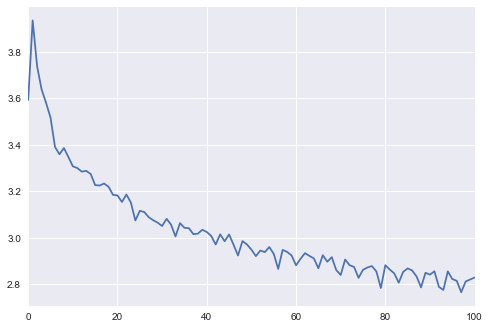

In [24]:
import pandas as pd
pd.Series(loss_history).plot()

## 8. Run tSNE to plot the embeddings

In [25]:
num_points = 5000
print (num_points)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000, n_iter_without_progress=30, verbose=1)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
print ("tSNE done...")

5000
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.236429
[t-SNE] KL divergence after 75 iterations with early exaggeration: 2.023939
[t-SNE] Error after 100 iterations: 2.023939
tSNE done...


In [26]:
two_d_embeddings.shape

(5000, 2)

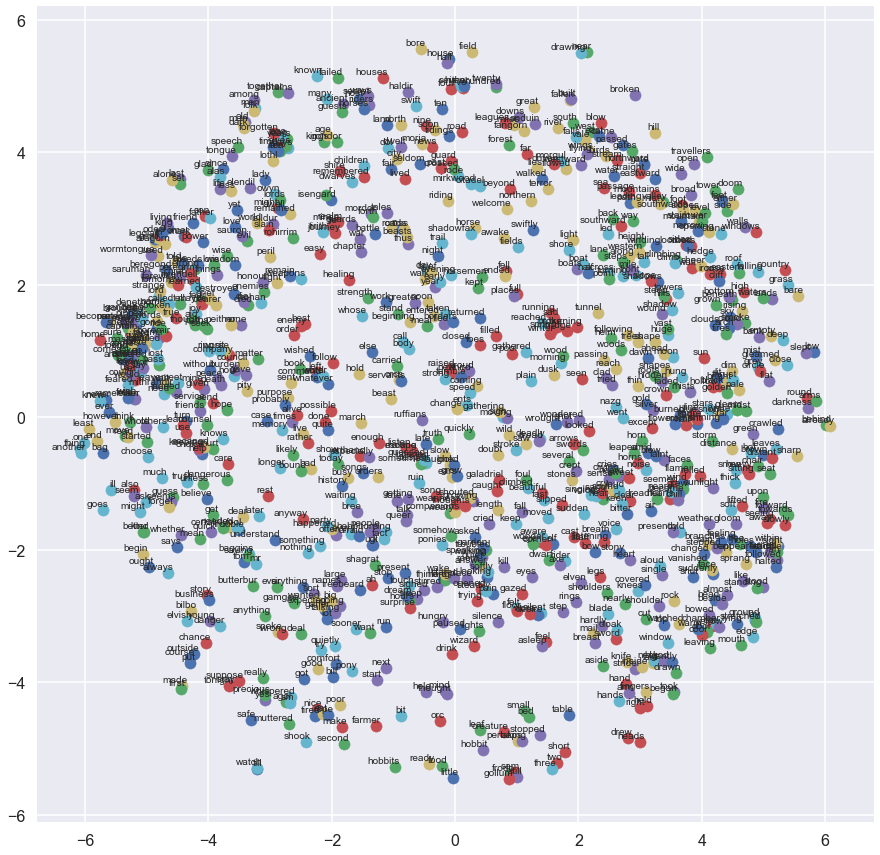

In [365]:
num_points = 1000
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words_2_plot = [reverse_dictionary[i] for i in range(1, num_points)]
plot(two_d_embeddings, words_2_plot)

## 9. Plot the scatter plots

In [27]:
total_indx = (5000)
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (reverse_dictionary[index], two_d_embeddings[index])
            for index in range(total_indx)
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
count[:5]

[['UNK', 539], ('said', 4111), ('frodo', 1991), ('sam', 1290), ('came', 1256)]

In [29]:
points.head(10)

,word,x,y
0,UNK,4.798220,-2.096607
1,said,0.065453,5.292968
2,frodo,-0.207875,5.288847
3,sam,-3.840404,-3.752920
4,came,-3.800578,-3.846769
5,great,4.984435,-2.041883
6,come,2.102680,5.496945
7,could,-3.394534,-3.948977
8,long,5.130568,-1.608549
9,would,-4.750541,2.719186


In [30]:
sns.set_context("poster")

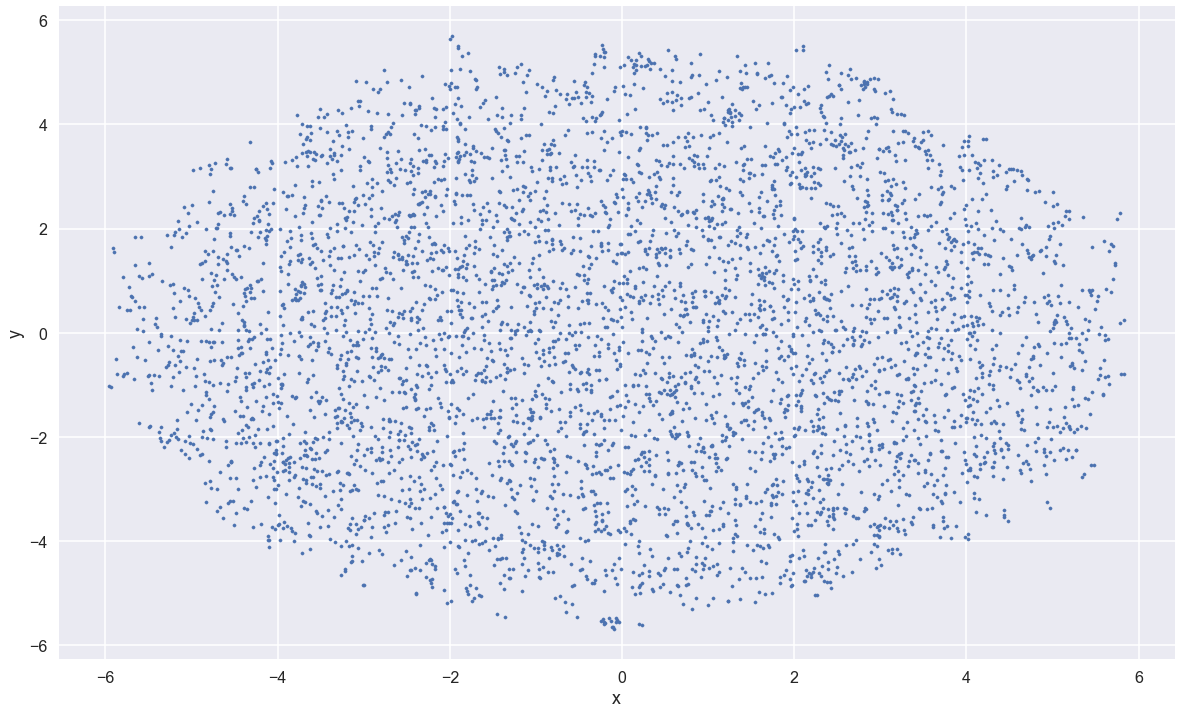

In [31]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))


In [32]:
def plot_region(x_bounds, y_bounds, x=0, y=0, title="titile"):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20, 10), title=title)
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=15)
    ax.text(x + 0.005, y + 0.005, title, fontsize=25)


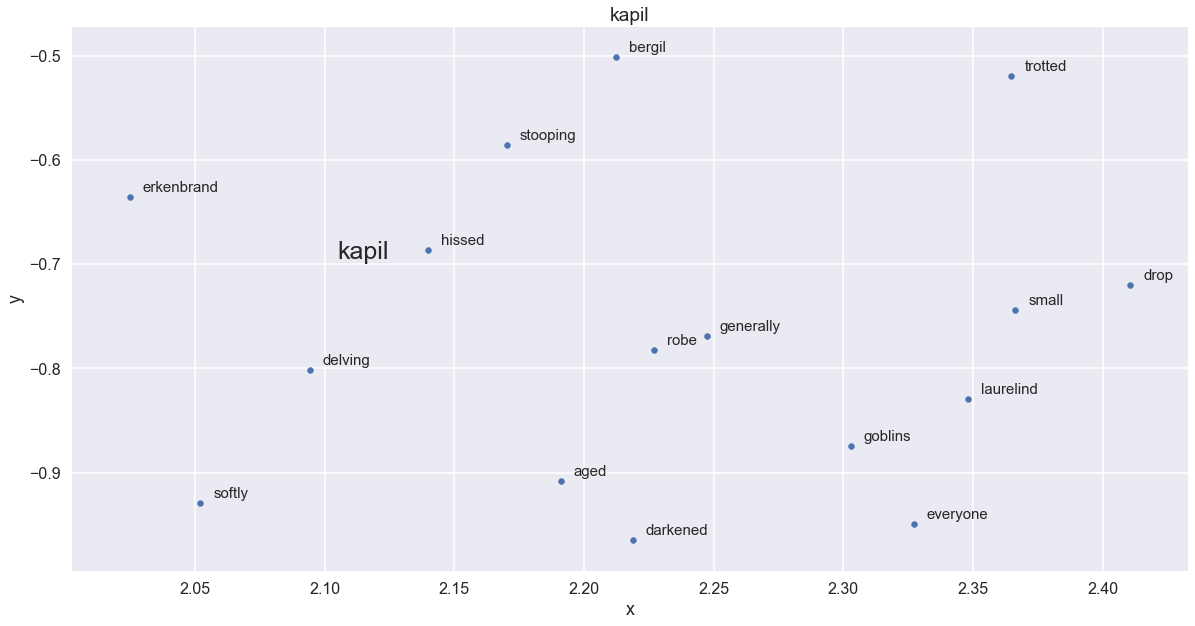

In [33]:
plot_region(x_bounds=(2.0, 2.5), y_bounds=(-1, -0.5), x=2.1, y=-0.7, title="kapil")


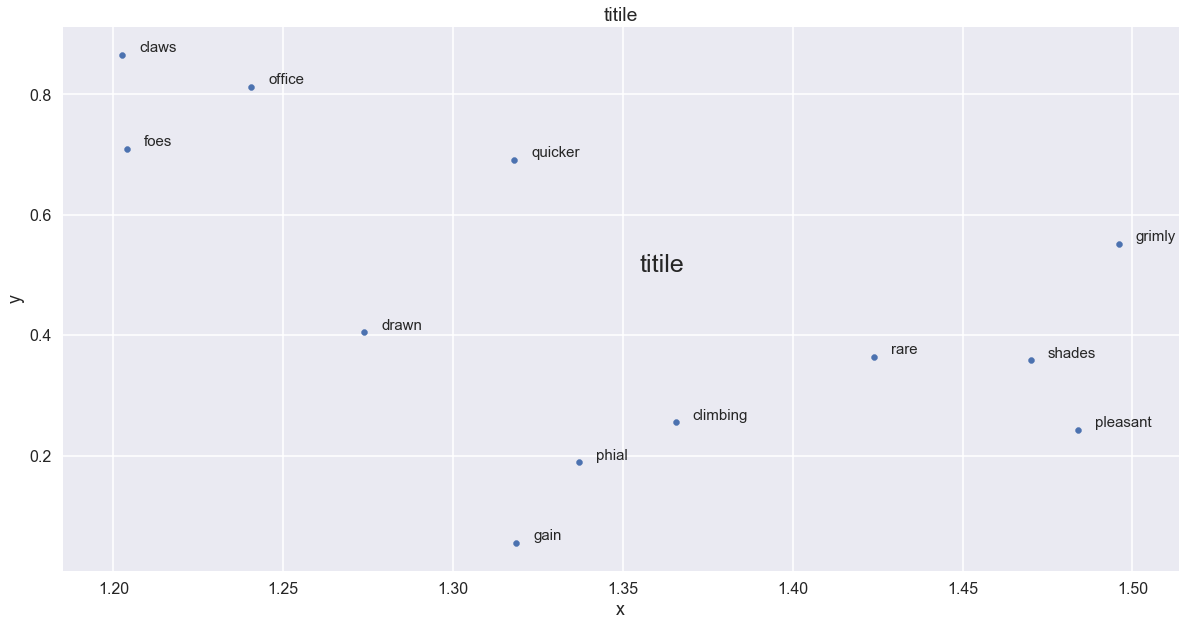

In [34]:
plot_region(x_bounds=(1.2, 1.5), y_bounds=(0, 1), x=(1.2+1.5)/2, y=(0+1)/2)

In [35]:
def get_similar_words(word_from):
    valid_word = dictionary[word_from]
    similarity = np.dot(final_embeddings[valid_word, np.newaxis] ,final_embeddings.T)
    top_k = 8 # number of nearest neighbors
    nearest = (-similarity[0, :]).argsort()[1:top_k+1]
    log = 'Nearest to %s:' % reverse_dictionary[valid_word]
    for k in range(top_k):
      close_word = reverse_dictionary[nearest[k]]
      log = '%s %s,' % (log, close_word)
    print(log)

In [57]:
known_words = ['frodo', 'sam', 'gandalf', 'rings', 'shire', 'lord', 'dark', 'enemy', 'merry', 'uncle', 
               'pippin', 'elves', 'hobbits', 'feet', 'treebeard', 'trees', 'man', 'rohan', 'gimli', 'axe', 'orcs', 
              'bow', 'war', 'army', 'precious']

In [58]:
for imp_word in known_words:
    get_similar_words(imp_word)

Nearest to frodo: sam, gollum, mr, faramir, rankle, helps, ssss, revolts,
Nearest to sam: frodo, gollum, master, right, hobbit, conical, voice, hand,
Nearest to gandalf: merry, aragorn, wormtongue, pippin, well, flash, saruman, king,
Nearest to rings: counter, smoked, ronald, silver, tolkien, purchased, masster, rashers,
Nearest to shire: bree, mined, instance, pickers, collapse, days, unthanked, serene,
Nearest to lord: denethor, golasgil, said, warden, say, abed, service, chieftain,
Nearest to dark: mirkwood, light, fought, greater, hesitatingly, even, casks, instructing,
Nearest to enemy: neighbours, test, deliver, contrive, ring, hope, grudgingly, striven,
Nearest to merry: pippin, flotsam, gandalf, treebeard, blanched, aragorn, ironmongery, speechless,
Nearest to uncle: fashioned, harfoots, k, suggests, flagstone, quote, swag, fondly,
Nearest to pippin: merry, gandalf, differ, aragorn, flotsam, gilded, beregond, steward,
Nearest to elves: folk, mischances, sorrows, days, men, nois

In [38]:
def plot_near_word(word):
    point_word = points[points['word'] == word]
    x = point_word['x'].values[0]
    y = point_word['y'].values[0]
    print (x, y)
    x_range = 1.0
    y_range = 1.0
    plot_region(x_bounds=(x - x_range, x + x_range), y_bounds=(y - y_range, y+ y_range), 
                x=x, y=y, title=word)

-0.207875279551 5.28884684358
-3.84040398115 -3.75292024809
5.34926041086 -0.360377715029
3.44223164186 1.20638127371
1.94874787705 -4.28309332538
2.92928430464 -3.87420348235
1.97150565554 -4.2666515644
0.620450320987 -1.22748112486
-0.737985429318 -0.119919985996
-0.472453665592 -2.83693364614
4.71016738324 -2.15414901469
-2.91528204504 -0.299332479726


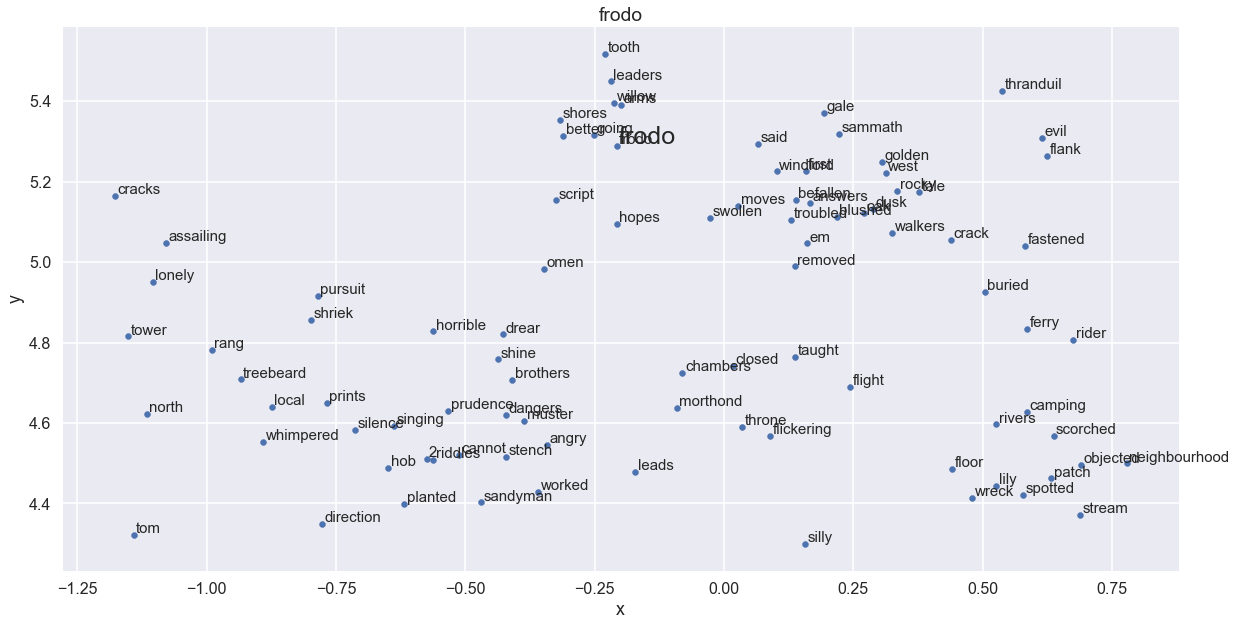

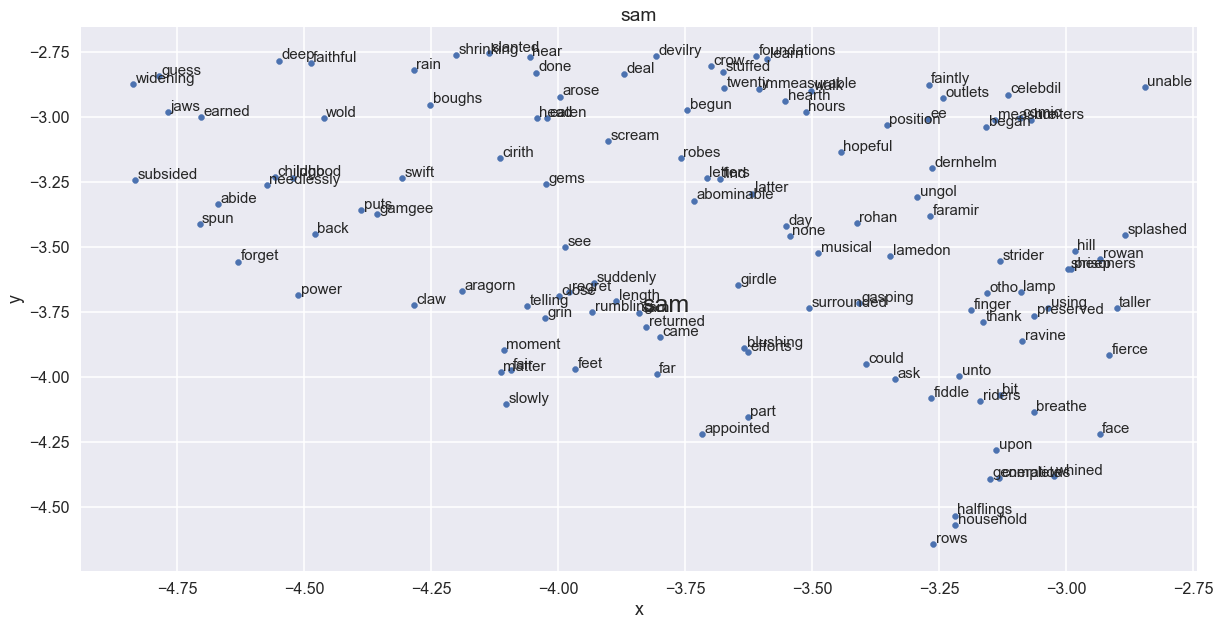

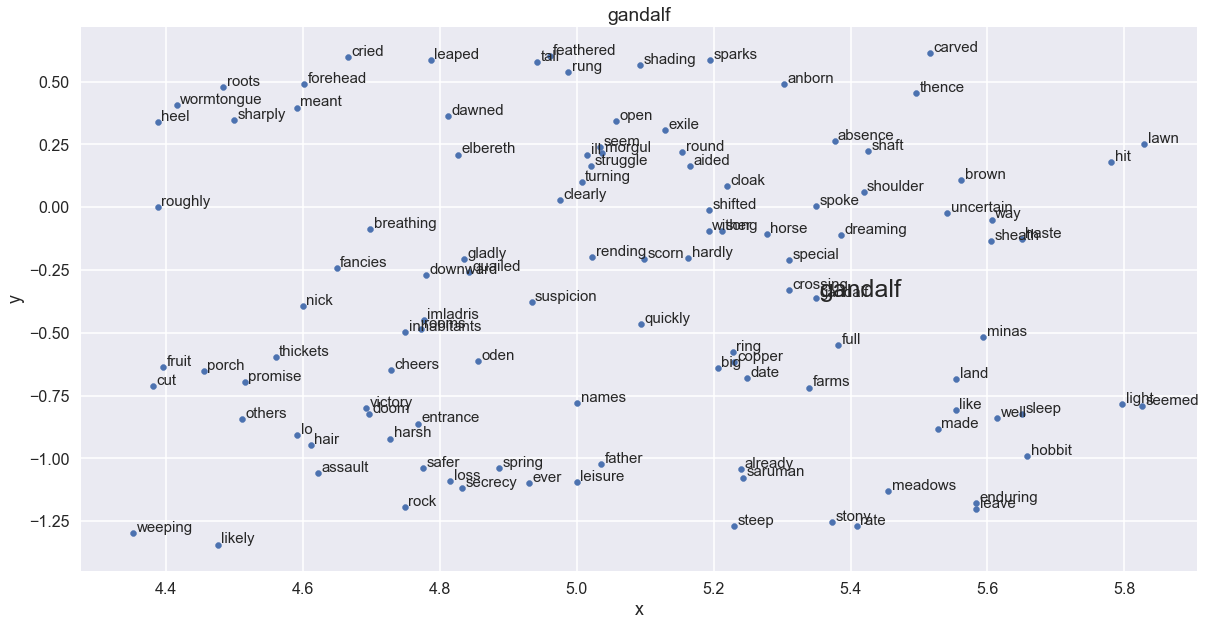

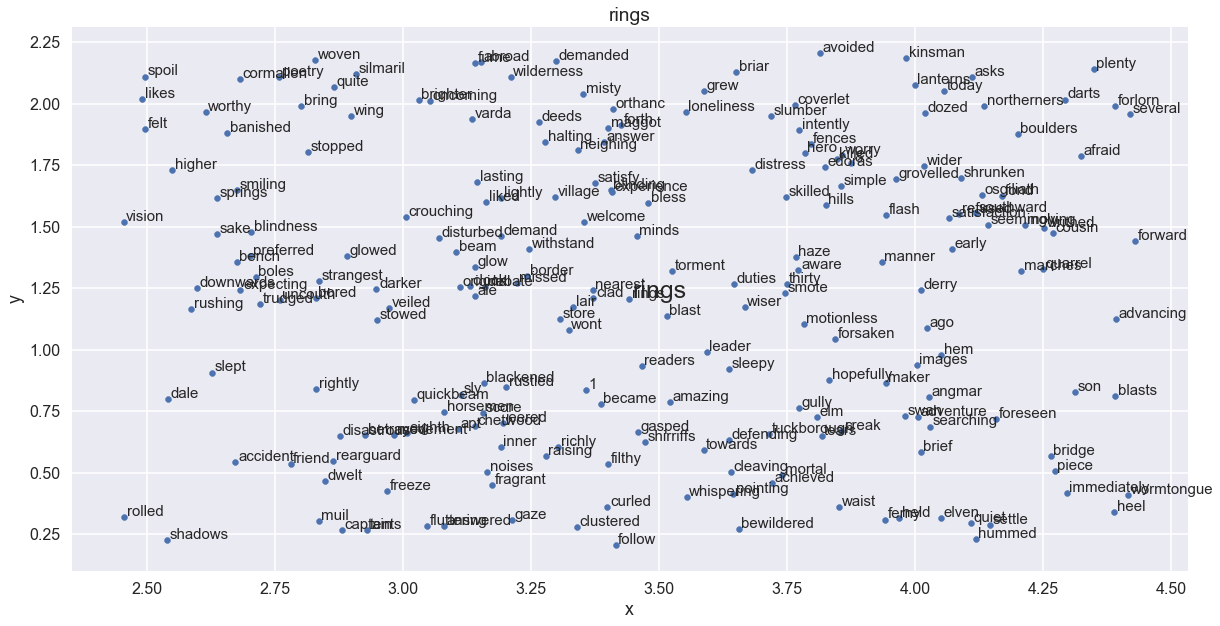

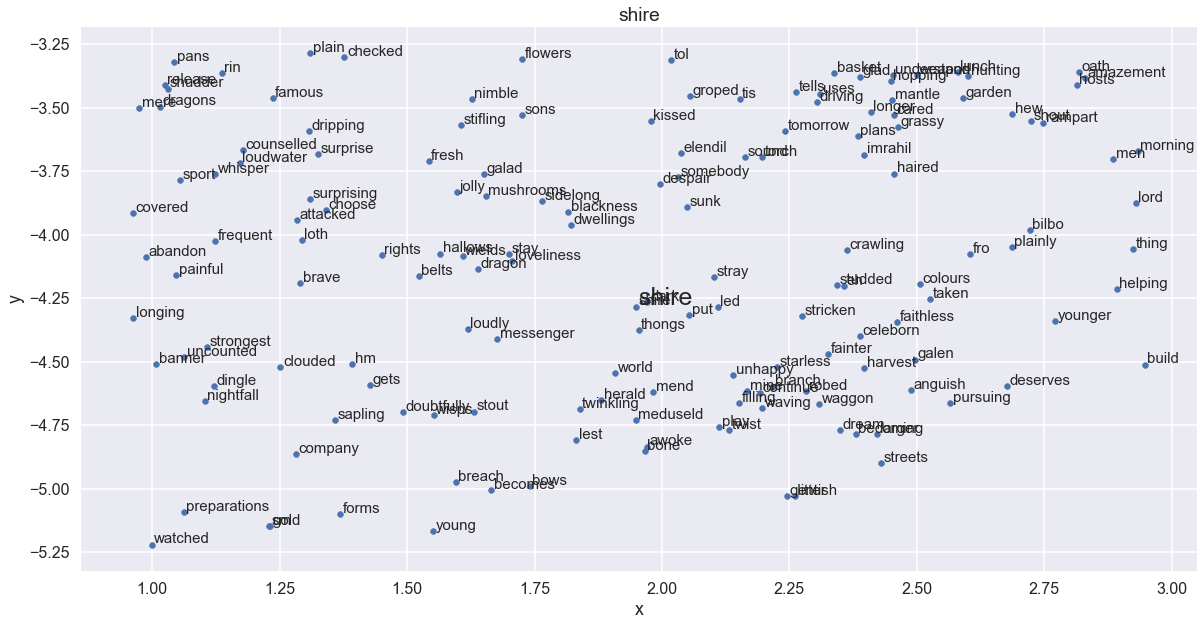

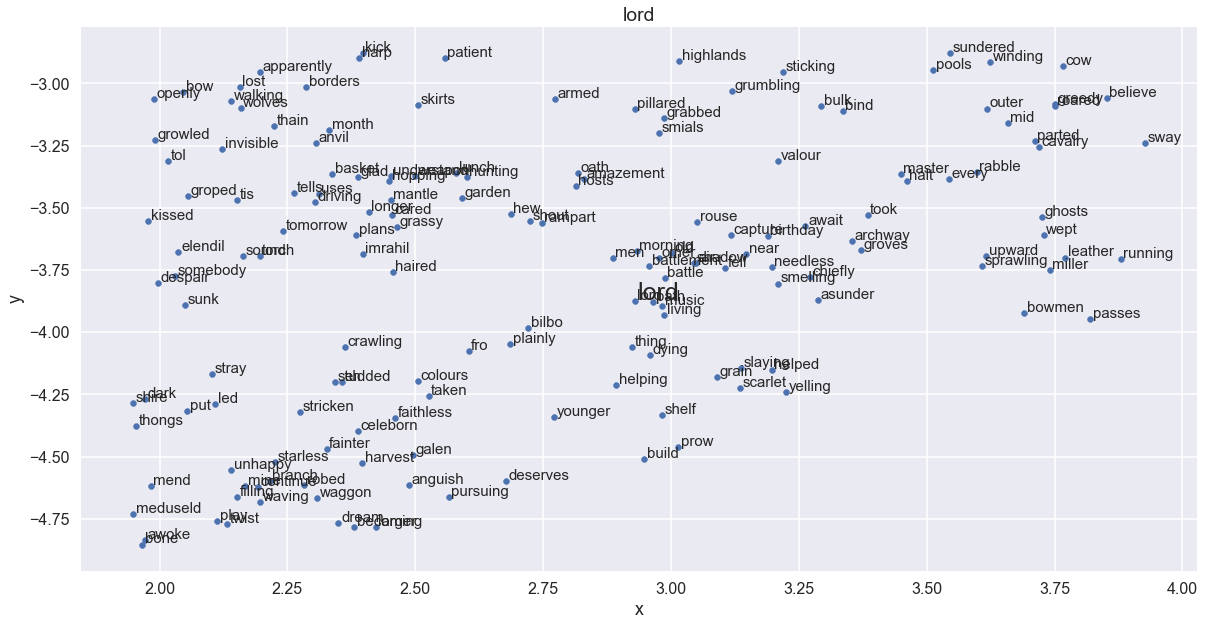

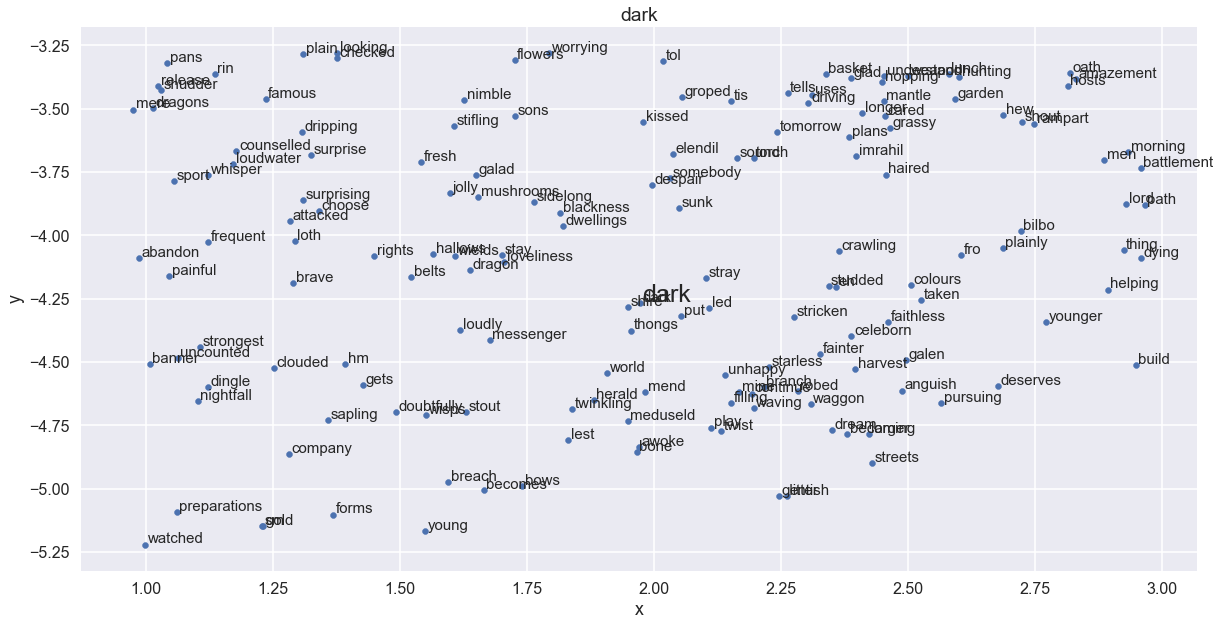

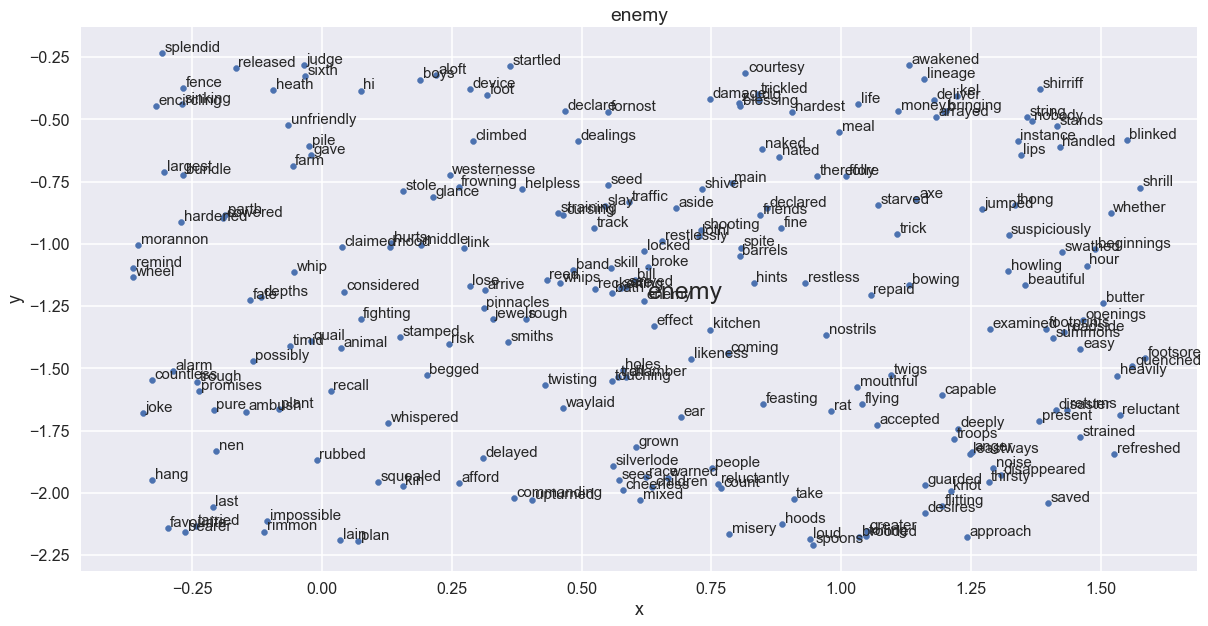

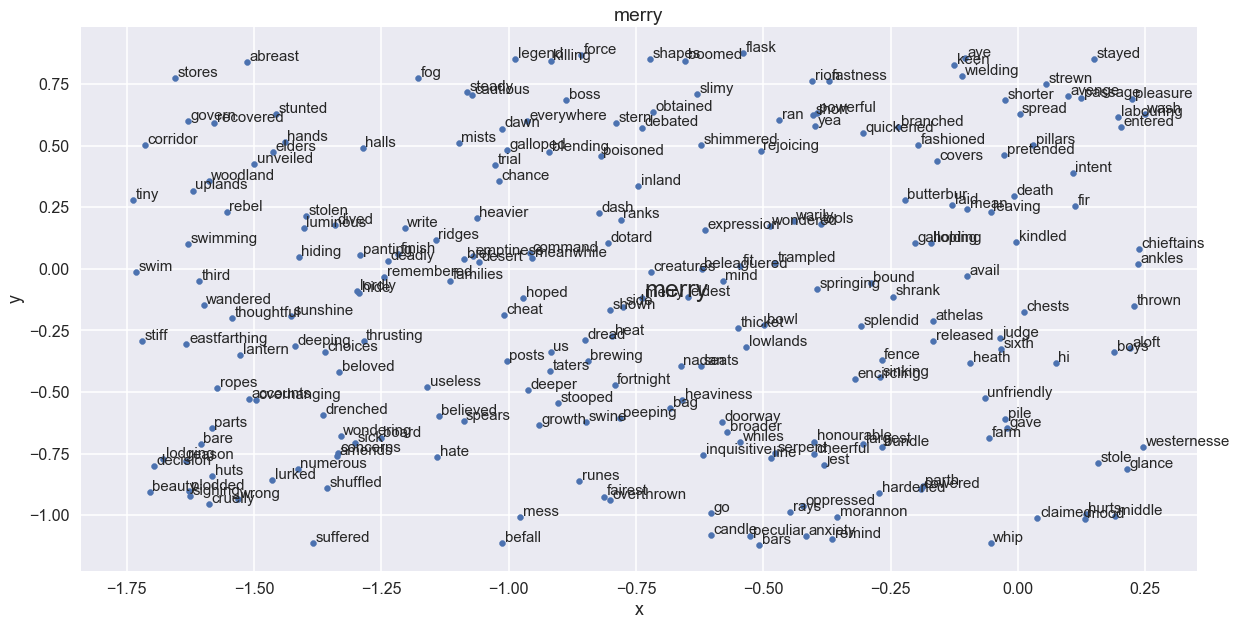

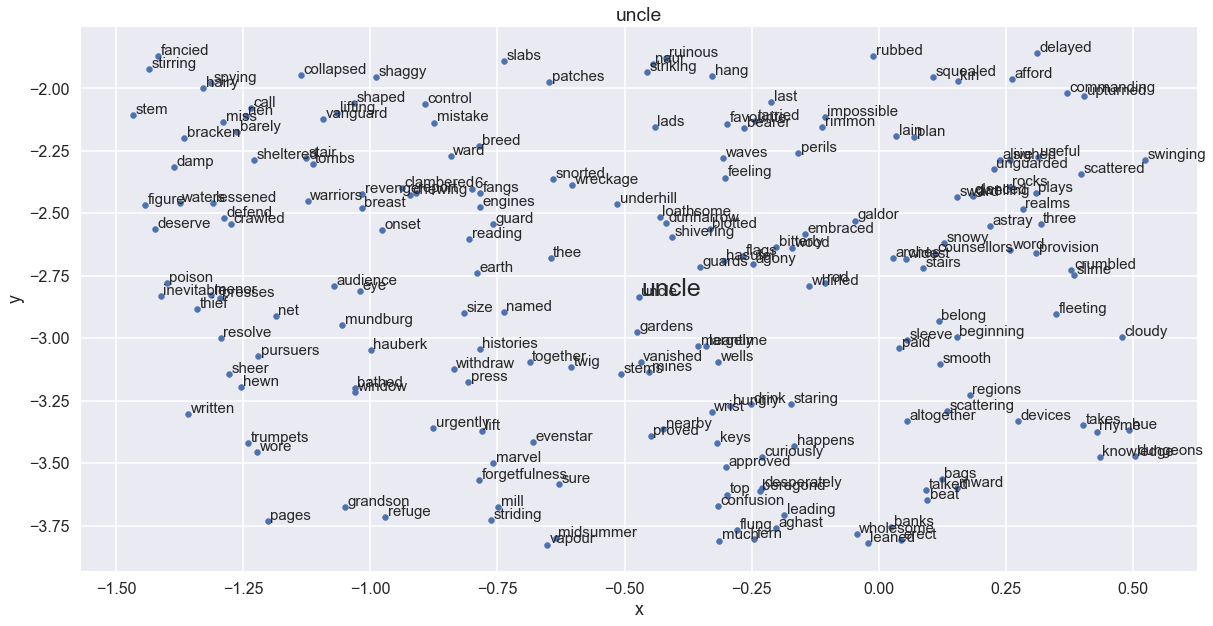

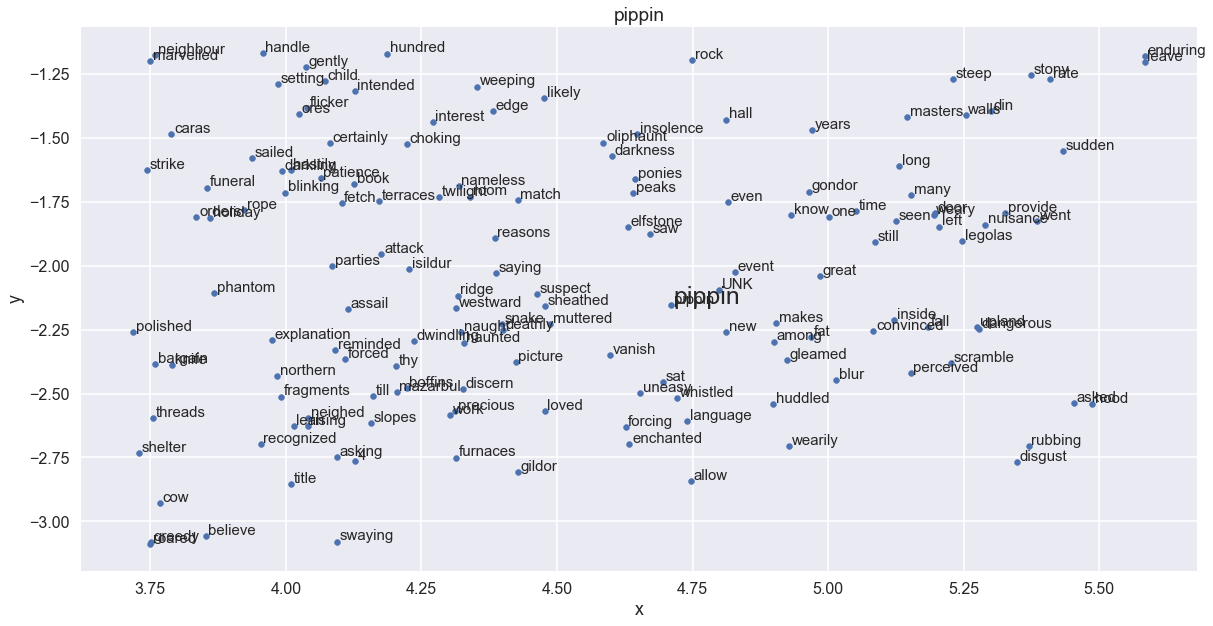

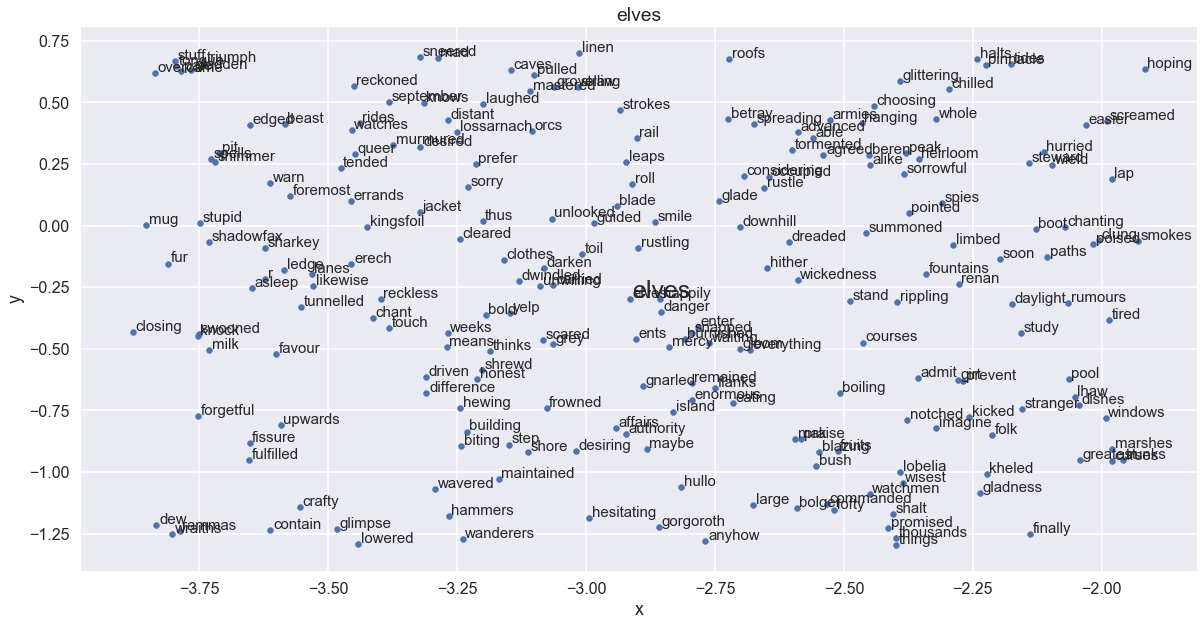

In [39]:
for imp_word in known_words:
    plot_near_word(imp_word)

# Using Python package

In [216]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [220]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [221]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/Users/kdalwani/anaconda2/envs/carnd3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [261]:
lort_2_vec = w2v.Word2Vec(
    sg=1,
    workers=num_workers,
    size=num_features,
    sample=downsampling,
    min_count=min_word_count,
    window=context_size)

In [262]:
lort_2_vec.build_vocab(sentences_splits)

2017-06-02 17:10:55,439 : INFO : collecting all words and their counts
2017-06-02 17:10:55,442 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-02 17:10:55,473 : INFO : PROGRESS: at sentence #10000, processed 152364 words, keeping 8911 word types
2017-06-02 17:10:55,501 : INFO : PROGRESS: at sentence #20000, processed 280245 words, keeping 11508 word types
2017-06-02 17:10:55,534 : INFO : PROGRESS: at sentence #30000, processed 434171 words, keeping 13882 word types
2017-06-02 17:10:55,546 : INFO : collected 14495 word types from a corpus of 485275 raw words and 32696 sentences
2017-06-02 17:10:55,548 : INFO : Loading a fresh vocabulary
2017-06-02 17:10:55,577 : INFO : min_count=3 retains 7347 unique words (50% of original 14495, drops 7148)
2017-06-02 17:10:55,579 : INFO : min_count=3 leaves 476041 word corpus (98% of original 485275, drops 9234)
2017-06-02 17:10:55,616 : INFO : deleting the raw counts dictionary of 14495 items
2017-06-02 17:10:55,618

In [242]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [264]:
token_count = sum([len(sentence) for sentence in sentences_splits])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 485,275 tokens


In [265]:
lort_2_vec.train(sentences_splits,  total_examples = token_count, epochs=20)

2017-06-02 17:13:04,887 : INFO : training model with 24 workers on 7347 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-06-02 17:13:08,787 : INFO : PROGRESS: at 0.01% examples, 1916 words/s, in_qsize 47, out_qsize 0
2017-06-02 17:13:12,479 : INFO : PROGRESS: at 0.18% examples, 24333 words/s, in_qsize 47, out_qsize 0
2017-06-02 17:13:13,578 : INFO : PROGRESS: at 0.33% examples, 40784 words/s, in_qsize 47, out_qsize 0
2017-06-02 17:13:16,581 : INFO : PROGRESS: at 0.34% examples, 30885 words/s, in_qsize 48, out_qsize 0
2017-06-02 17:13:20,479 : INFO : PROGRESS: at 0.51% examples, 34539 words/s, in_qsize 47, out_qsize 0
2017-06-02 17:13:21,531 : INFO : PROGRESS: at 0.62% examples, 39025 words/s, in_qsize 47, out_qsize 0
2017-06-02 17:13:24,508 : INFO : PROGRESS: at 0.67% examples, 36454 words/s, in_qsize 46, out_qsize 1
2017-06-02 17:13:25,607 : INFO : PROGRESS: at 0.80% examples, 40893 words/s, in_qsize 48, out_qsize 0
2017-06-02 17:13:28,282 : INFO : PR

7156104

In [266]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [267]:
lort_2_vec.save(os.path.join("trained", "lort_2_vec.w2v"))

2017-06-02 17:16:03,142 : INFO : saving Word2Vec object under trained/lort_2_vec.w2v, separately None
2017-06-02 17:16:03,144 : INFO : not storing attribute syn0norm
2017-06-02 17:16:03,146 : INFO : not storing attribute cum_table
2017-06-02 17:16:03,372 : INFO : saved trained/lort_2_vec.w2v


In [268]:
lort_2_vec = w2v.Word2Vec.load(os.path.join("trained", "lort_2_vec.w2v"))

2017-06-02 17:16:06,418 : INFO : loading Word2Vec object from trained/lort_2_vec.w2v
2017-06-02 17:16:06,569 : INFO : loading wv recursively from trained/lort_2_vec.w2v.wv.* with mmap=None
2017-06-02 17:16:06,571 : INFO : setting ignored attribute syn0norm to None
2017-06-02 17:16:06,573 : INFO : setting ignored attribute cum_table to None
2017-06-02 17:16:06,575 : INFO : loaded trained/lort_2_vec.w2v


In [276]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, verbose=1)

In [277]:
all_word_vectors_matrix = lort_2_vec[lort_2_vec.wv.vocab]
all_word_vectors_matrix.shape

(7347, 300)

In [278]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix[0:4000, :])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 1.026364
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.000784
[t-SNE] Error after 250 iterations: 1.000784


In [290]:
points_array = []
for word in lort_2_vec.wv.vocab:
    index = lort_2_vec.wv.vocab[word].index
    if index < all_word_vectors_matrix_2d.shape[0]:
        cordss = all_word_vectors_matrix_2d[lort_2_vec.wv.vocab[word].index]
        points_array.append([word, cordss[0], cordss[1]])

points = pd.DataFrame(points_array,     columns=["word", "x", "y"])

In [291]:
points.head()

,word,x,y
0,trumpets,3.757402,2.756175
1,raiment,7.459575,3.525379
2,gully,-2.042900,5.738862
3,King,2.670471,5.312121
4,packing,1.309938,4.519753


In [292]:
sns.set_context("poster")

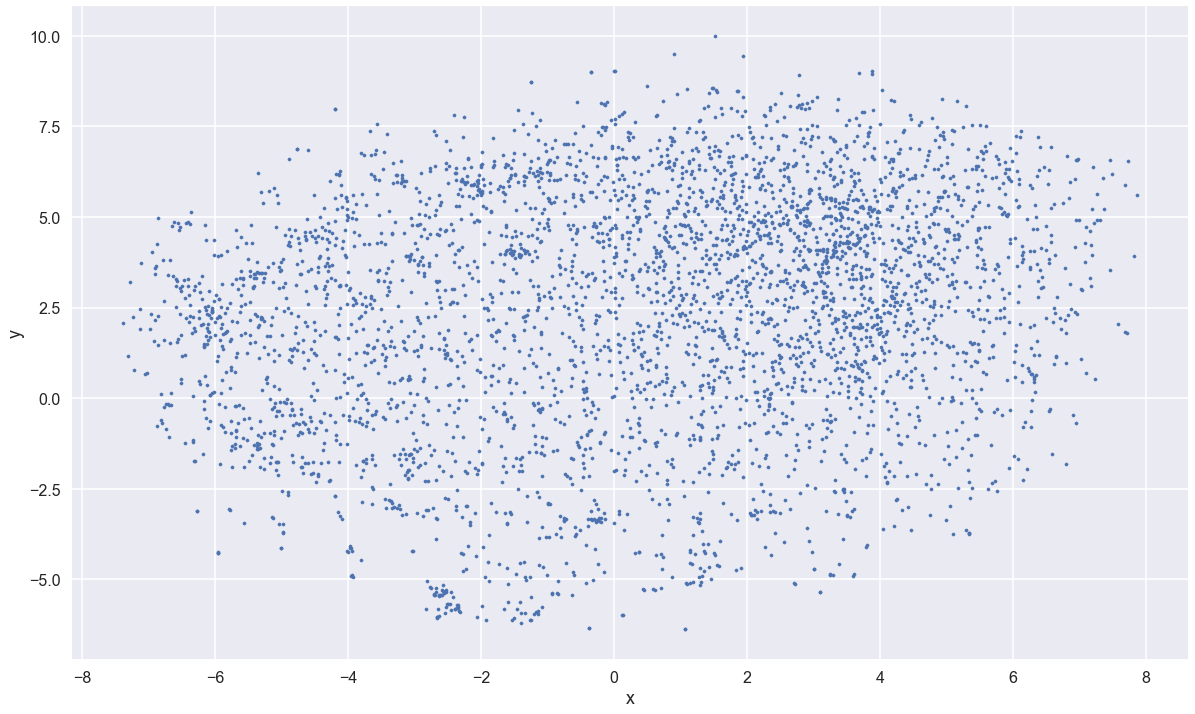

In [293]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [304]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=15)

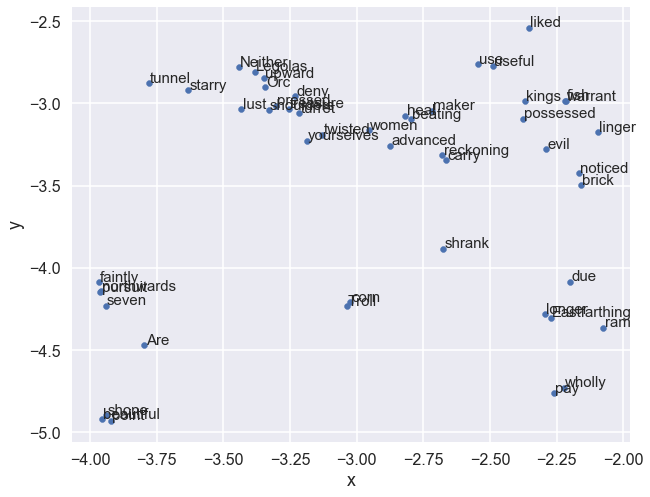

In [305]:
plot_region(x_bounds=(-4.0, -2), y_bounds=(-5, -2.5))

In [308]:
lort_2_vec.wv.vocab

{'trumpets': <gensim.models.keyedvectors.Vocab at 0x13046ee10>,
 'sip': <gensim.models.keyedvectors.Vocab at 0x1304dd160>,
 'raiment': <gensim.models.keyedvectors.Vocab at 0x1304dd198>,
 'gully': <gensim.models.keyedvectors.Vocab at 0x1304dd1d0>,
 'King': <gensim.models.keyedvectors.Vocab at 0x1304dd208>,
 'briar': <gensim.models.keyedvectors.Vocab at 0x1304dd240>,
 'feathers': <gensim.models.keyedvectors.Vocab at 0x1304dd278>,
 'uneven': <gensim.models.keyedvectors.Vocab at 0x1304dd2b0>,
 'chased': <gensim.models.keyedvectors.Vocab at 0x1304dd2e8>,
 'packing': <gensim.models.keyedvectors.Vocab at 0x1304dd320>,
 'Quick': <gensim.models.keyedvectors.Vocab at 0x130b57f98>,
 'Light': <gensim.models.keyedvectors.Vocab at 0x1304dd358>,
 'skill': <gensim.models.keyedvectors.Vocab at 0x1304dd3c8>,
 'greedy': <gensim.models.keyedvectors.Vocab at 0x1304dd400>,
 'distrust': <gensim.models.keyedvectors.Vocab at 0x1304e2390>,
 'circling': <gensim.models.keyedvectors.Vocab at 0x130b79c88>,
 'birthd

In [326]:
lort_2_vec.most_similar("enemy")

[('waylay', 0.3318626284599304),
 ('scout', 0.3257095217704773),
 ('Need', 0.32555195689201355),
 ('hastening', 0.3213416337966919),
 ('sortie', 0.30534788966178894),
 ('Draw', 0.30172038078308105),
 ('storm', 0.2984728217124939),
 ('fills', 0.29738885164260864),
 ('defence', 0.2931402325630188),
 ('foremost', 0.2930784821510315)]